# Box Model - Self Check Example

## Model Description 
This is a steady state box model 

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is constant flow with a total of 6.25 m3/day leaving the domain.  
 - Left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. 

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Create the model object

In [2]:
modelname = "BoxModel_Check"
moddir="/Applications/MODFLOW/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"

In [3]:
#optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : http://modflowpy.github.io/flopydoc/mfdis.html

#### 3.1 Spatial discretization

In [4]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 10.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

#### 3.2 Temporal discretization 

In [5]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [6]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://modflowpy.github.io/flopydoc/plotutil.html

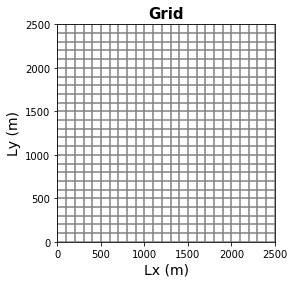

In [7]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: http://modflowpy.github.io/flopydoc/mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [8]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [9]:
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 7    #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

#### 4.3 Create BAS object

In [10]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

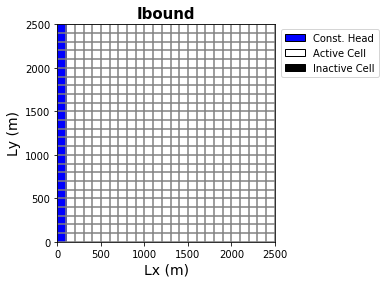

In [11]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: http://modflowpy.github.io/flopydoc/mflpf.html

#### 5.1 Set layer properties

In [12]:
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#### 5.2 Make LPF object

In [13]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: http://modflowpy.github.io/flopydoc/mfoc.html

#### 6.1 Setup outputs

In [14]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 6.2 Make OC object 

In [15]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [16]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

#### 8.1 Setup the well parameters

In [17]:
Q_in = -6.25                         #total flow crossing right boundary (m3/day)
Q_cell = Q_in / nrow                 #flow entering each cell (m3/day)
fluxes = np.zeros((nrow,4))          #create array of zeros (# of rows, # of parameters: [lay, row, col, flux])
for i in range(nrow):                #iterate over rows & assign constant flux to each cell in leftmost column
    fluxes[i,:] = [0,i,ncol-1,Q_cell]     #[lay, row, col, flux]
#print(fluxes)

sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period

#print(sp_fluxes)

#### 8.2 Make the WEL object

In [18]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

## 9. Write inputs and run the model 

#### 9.1 Write Inputs

In [19]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 9.2 Run the model

In [20]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: BoxModel_Check.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/28 17:46:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/28 17:46:24
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


## 10. Plot the results  

#### 10.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [21]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [22]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


##### Read the Water Balance

In [23]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)
#print("Flow through Right Face of Grid Cells m^3/d \n", frf,
#     "\n Flow through Front Face of Grid Cells m^3/d \n", fff)


#### 10.2 Evaluate the head gradients

Head Gradient 0.0003668985366821289 m/m


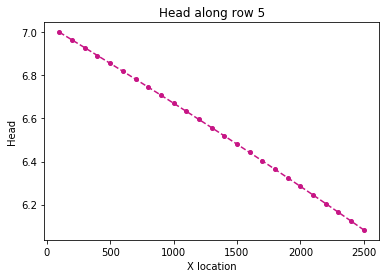

In [24]:
head_fig = plt.figure() 
x=np.arange(100,2600,100) 
y=head[0,5,:]
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 5")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,5,0]-head[0,5,-1])/Lx
print("Head Gradient", hgrad, "m/m") 

#### 10.3 3D plot of heads

Text(0.5, 0.92, 'Steady-State Model Head Profile')

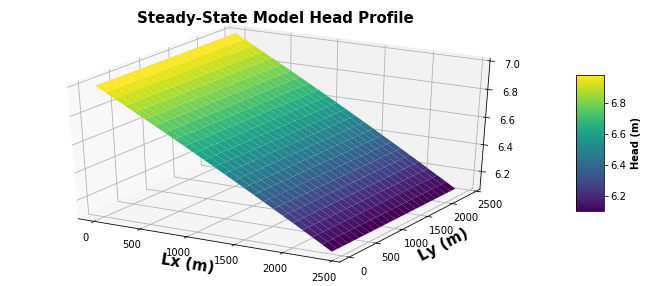

In [25]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

####  10.4 Contour Head plot

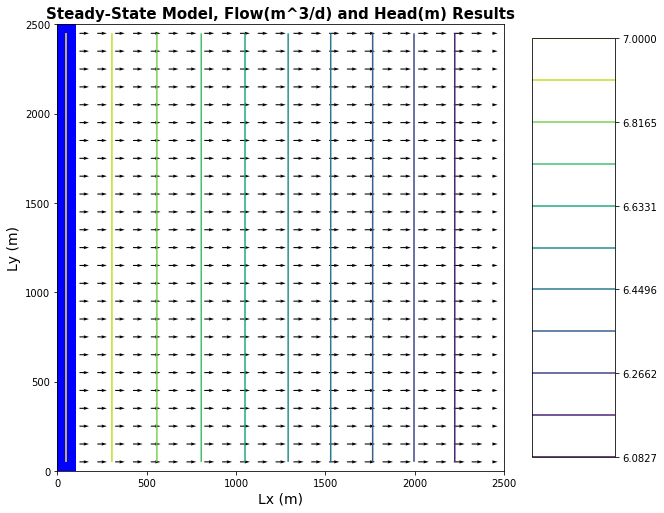

In [26]:
#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)

#### 10.5 Alternate contour plot with saving

Text(0.5, 1.0, 'Box Model Heads (m)')

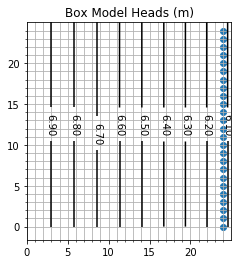

In [27]:
#Create second contour figure & plot data
fig2 = plt.figure()                     #create figure and return a figure object
ax1 = plt.subplot(1,1,1,aspect='equal') #in current figure, create & return axes at position (row, col, index)
levels = np.arange(1,10,0.1)           #creates an array of values from 1 to 9 with a step size of 1, used to determine which contour values to draw
extent = (0, ncol, 0, nrow)              #sets plot boundaries (x0,x1,y0,y1)
c = plt.contour(head[0,:,:], extent=extent, levels=levels, colors='k')  #plots contours for all rows & columns in layer 1
s = plt.scatter(fluxes[:,2], fluxes[:,1])    #plots well locations (col = x, row = y)

#Format grid & axes:
major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

ax1.set_xticks(major_ticks)             #sets major ticks
ax1.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.grid(which='both')                  #turns grid on for both major and minor ticks

#Labels:
plt.clabel(c, fmt='%1.2f')              #adds contour labels as floats with 2 decimal places       
plt.title('Box Model Heads (m)')        #adds a title

# plt.savefig('BoxModel_head_contours.png')   

#### 10.6 Additional 3D plot

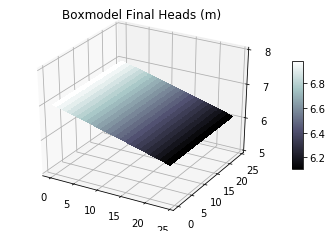

In [28]:
#Create data arrays to plot
X = np.arange(25)         #create an array of x values corresponding to model columns
Y = np.arange(25)         #create an array of y values corresponding to model rows
X, Y = np.meshgrid(X, Y)  #create a 2D grid for X and Y values
Z = head[0,:,:]           #assign heads as Z values
    
#Plot surface
fig3 = plt.figure()               #create figure object
ax3 = fig3.gca(projection='3d')   #set 3D axes
surf = ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.bone, linewidth=0, antialiased=False)    #plot surface
    
#Format plot
fig3.colorbar(surf, shrink=0.5, aspect=10)   #display colorbar for surface
#ax3.set_zlim(zbot,ztop, dz)                #set axis limits & spacing
ax3.set_zlim(5,8)                #set axis limits & spacing
plt.title('Boxmodel Final Heads (m)')       #add title
    
#Optional extra formatting specifications (uncomment to run)
#ax3.set_xlim(0,Lx, dx)
#ax3.set_ylim(0,Ly, delc)
plt.locator_params(axis='z', nbins=5)    #set axis step size
#plt.locator_params(axis='y', nbins=nrow)
#plt.locator_params(axis='x', nbins=ncol)

# fig3.savefig('Boxmodel_head_surface.png')       